In [109]:
from IPython.core.display import HTML
HTML("\n".join(open('mioti_style.css', 'r').readlines()))

<img src="mioti.png" style="height: 100px">
<center style="color:#888">Módulo Data Science in IoT<br/>Asignatura Machine Learning</center>
# Challenge S2: Reconocimiento de dígitos

## Objetivo

Nuestro objetivo en este challenge es implementar un mecanismo automático que a partir de una imagen de un cheque sea capaz de reconocer la cantidad manuscrita que hay en el mismo.

<img src="cheque.jpg">

Para ello trabajaremos con un dataset abierto denominado `digits` que contiene dígitos manuscritos etiquetados.

## Configuración del entorno

In [110]:
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix

## Carga de datos

En esta ocasión vamos a utilizar una dataset denominado 'digits' que contiene imágenes de números manuscritos.

Este dataset está disponible dentro de los datasets de `sklearn` y podemos cargarlo en memoria de la siguiente manera:

In [111]:
from sklearn.datasets import load_digits
digits = load_digits()

In [112]:
print(digits)

{'data': array([[ 0.,  0.,  5., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ..., 10.,  0.,  0.],
       [ 0.,  0.,  0., ..., 16.,  9.,  0.],
       ...,
       [ 0.,  0.,  1., ...,  6.,  0.,  0.],
       [ 0.,  0.,  2., ..., 12.,  0.,  0.],
       [ 0.,  0., 10., ..., 12.,  1.,  0.]]), 'target': array([0, 1, 2, ..., 8, 9, 8]), 'target_names': array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), 'images': array([[[ 0.,  0.,  5., ...,  1.,  0.,  0.],
        [ 0.,  0., 13., ..., 15.,  5.,  0.],
        [ 0.,  3., 15., ..., 11.,  8.,  0.],
        ...,
        [ 0.,  4., 11., ..., 12.,  7.,  0.],
        [ 0.,  2., 14., ..., 12.,  0.,  0.],
        [ 0.,  0.,  6., ...,  0.,  0.,  0.]],

       [[ 0.,  0.,  0., ...,  5.,  0.,  0.],
        [ 0.,  0.,  0., ...,  9.,  0.,  0.],
        [ 0.,  0.,  3., ...,  6.,  0.,  0.],
        ...,
        [ 0.,  0.,  1., ...,  6.,  0.,  0.],
        [ 0.,  0.,  1., ...,  6.,  0.,  0.],
        [ 0.,  0.,  0., ..., 10.,  0.,  0.]],

       [[ 0.,  0.,  0., ..., 12.,  0

Inspeccionando el dataset podemos ver que es un diccionario. Vamos a navegar un poco en sus propiedades:

In [113]:
digits.keys()

dict_keys(['data', 'target', 'target_names', 'images', 'DESCR'])

En la etiqueta `DESCR` tenemos la descripción del dataset:

In [114]:
print(digits['DESCR'])

.. _digits_dataset:

Optical recognition of handwritten digits dataset
--------------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 5620
    :Number of Attributes: 64
    :Attribute Information: 8x8 image of integer pixels in the range 0..16.
    :Missing Attribute Values: None
    :Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)
    :Date: July; 1998

This is a copy of the test set of the UCI ML hand-written digits datasets
http://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where
each class refers to a digit.

Preprocessing programs made available by NIST were used to extract
normalized bitmaps of handwritten digits from a preprinted form. From a
total of 43 people, 30 contributed to the training set and different 13
to the test set. 32x32 bitmaps are divided into nonoverlapping blocks of
4x4 and the number of on pixels are counted in each bloc

Podemos ver que en la variable `data` están almacenados los datos.

In [115]:
print(digits.data)

[[ 0.  0.  5. ...  0.  0.  0.]
 [ 0.  0.  0. ... 10.  0.  0.]
 [ 0.  0.  0. ... 16.  9.  0.]
 ...
 [ 0.  0.  1. ...  6.  0.  0.]
 [ 0.  0.  2. ... 12.  0.  0.]
 [ 0.  0. 10. ... 12.  1.  0.]]


In [116]:
print(digits.data.shape)

(1797, 64)


Y viendo su estructura, concluimos que contiene $1797$ instancias, cada una contiene $64$ características.

Además hay un vector:

In [117]:
print(digits.target)

[0 1 2 ... 8 9 8]


In [118]:
print(len(digits.target))
print(digits.target)

1797
[0 1 2 ... 8 9 8]


In [119]:
print(digits.target.shape)

(1797,)


Que contiene la clase real de cada instancia.

Tambien disponemos de las imagenes sin "aplanar". Pero para el entrenamiento y las predicciones usamos las imagenes "aplanadas".

In [120]:
print (digits.images.shape)

(1797, 8, 8)


Para estar seguros de que estamos interpretando el dataset podemos dibujarlo de la siguiente manera:

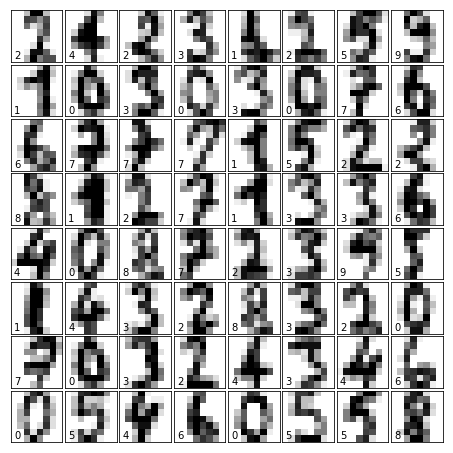

In [121]:
import random

fig = plt.figure(figsize=(6, 6))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

random.seed(42)
for i in range(64):
    pos = random.randint(0, len(digits.images) - 1)
    ax = fig.add_subplot(8, 8, i + 1, xticks=[], yticks=[])
    ax.imshow(digits.images[pos], cmap=plt.cm.binary, interpolation='nearest')
    ax.text(0, 7, str(digits.target[pos]))

In [122]:
print("Valor maximo de codificacion de los pixeles: ",np.max(digits.data))
print("Valor minimo de codificacion de los pixeles: ",np.min(digits.data))

Valor maximo de codificacion de los pixeles:  16.0
Valor minimo de codificacion de los pixeles:  0.0


## Conjunto de entrenamiento y test

Divide el conjunto de datos en 2 grupos: entrenamiento y test con una proporción de reparto del 30% (70% entrenamiento, 30% test)

* ¿Cuántos elementos tiene el conjunto de entrenamiento? ¿Y el de test?

In [123]:
from sklearn.model_selection import train_test_split

dataset_X = digits.data
dataset_y = digits.target
X_train, X_test, y_train, y_test = train_test_split(dataset_X, dataset_y, test_size=.3, random_state=42)

In [124]:
print(len(X_train))
print(len(X_test))

1257
540


## Clasificador logístico

Entrena un clasificador logístico para reconocer digitos.

* ¿Qué porcentaje de acierto obtienes?
* ¿Cuales son las clases que más se equivocan entre sí? ¿son lógicos los resultados?

In [125]:
from sklearn.linear_model import LogisticRegression

logistic = LogisticRegression()
logistic.fit(X_train, y_train)
y_predicted = logistic.predict(X_test)

In [126]:
print(y_predicted)
print(y_test)

[6 9 3 7 2 1 5 2 5 2 1 8 4 0 4 2 3 7 8 8 4 3 9 7 1 6 3 5 6 3 4 9 1 4 4 6 9
 4 7 6 6 9 1 3 6 1 3 0 6 5 5 1 9 5 6 0 9 0 0 1 0 4 5 2 4 5 7 0 7 5 9 5 5 4
 7 0 4 5 5 9 9 0 2 3 8 0 6 4 4 9 1 2 8 3 5 2 9 4 4 4 4 3 5 3 1 3 5 9 4 2 7
 7 4 4 1 9 2 7 8 7 2 6 9 4 0 7 2 7 5 8 7 5 7 9 0 6 6 4 2 8 0 9 4 6 9 9 6 9
 0 5 5 6 6 0 6 4 3 9 3 8 7 2 9 0 4 5 3 6 5 8 9 8 4 2 1 3 7 7 2 2 3 9 8 0 3
 2 2 5 6 9 9 4 1 2 4 2 3 6 4 8 5 9 5 7 8 9 4 8 1 5 4 4 9 6 1 8 6 0 4 5 2 7
 1 6 4 5 6 0 3 2 3 6 7 1 5 1 4 7 6 5 8 5 5 1 5 2 8 8 9 8 7 6 2 2 2 3 4 8 8
 3 6 0 9 7 7 0 1 0 4 5 8 5 3 6 0 4 1 0 0 3 6 5 9 7 3 5 5 9 9 8 5 3 3 2 0 5
 8 3 4 0 2 4 6 4 3 4 5 0 5 2 1 3 1 4 1 1 7 0 1 5 2 1 2 8 7 0 6 4 8 8 5 1 8
 4 5 8 7 9 8 8 0 6 2 0 7 9 1 9 5 2 7 7 1 8 7 4 3 8 3 5 6 0 0 3 0 5 0 0 4 1
 2 8 4 5 9 6 3 1 8 8 4 2 3 8 9 8 8 5 0 6 3 3 7 1 6 4 1 2 1 8 6 4 7 4 8 3 4
 0 5 1 9 4 5 7 6 3 7 0 5 9 7 5 9 7 4 2 2 9 0 7 5 8 3 6 3 9 6 9 5 0 1 5 5 8
 3 3 6 2 6 5 7 2 0 8 7 3 7 0 2 2 3 5 8 7 3 6 5 9 9 2 1 6 3 0 7 1 1 9 6 1 8
 0 0 2 9 3 9 9 3 7 7 1 3 

#### Porcentaje de acierto

In [127]:
#Porcentaje de acierto
print(logistic.score(X_test, y_test))

0.9537037037037037


#### Matriz confusión

In [128]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_predicted)


array([[52,  0,  0,  0,  1,  0,  0,  0,  0,  0],
       [ 0, 43,  1,  0,  0,  0,  0,  0,  6,  0],
       [ 0,  0, 47,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 52,  0,  1,  0,  0,  1,  0],
       [ 0,  1,  0,  0, 59,  0,  0,  0,  0,  0],
       [ 0,  2,  1,  0,  0, 61,  0,  1,  1,  0],
       [ 0,  0,  0,  0,  0,  1, 52,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 54,  0,  1],
       [ 0,  1,  0,  0,  0,  1,  0,  0, 41,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  5, 54]])

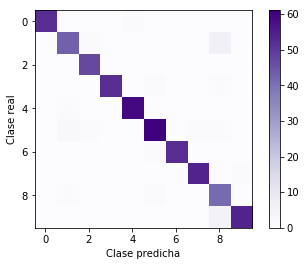

In [129]:
plt.imshow(confusion_matrix(y_test, y_predicted), cmap="Purples")
plt.colorbar()
plt.xticks()
plt.yticks()
plt.xlabel("Clase predicha")
plt.ylabel("Clase real");

## Perceptrón multicapa

Entrena un perceptrón multicapa con los datos anteriores (revisa el worksheet si no te acuerdas de como hacerlo).

* ¿Qué porcentaje de acierto obtienes?
* ¿Cuales son las clases que más se equivocan entre sí?
* Compara los resultados del perceptrón y el logístico

In [130]:
from sklearn.neural_network import MLPClassifier
nn = MLPClassifier()

nn.fit(X_train, y_train)
y_predicted_nn = nn.predict(X_test)

In [131]:
print(y_predicted_nn)
print(y_test)

[6 9 3 7 2 1 5 2 5 2 1 9 4 0 4 2 3 7 8 8 4 3 9 7 5 6 3 5 6 3 4 9 1 4 4 6 9
 4 7 6 6 9 1 3 6 1 3 0 6 5 5 1 9 5 6 0 9 0 0 1 0 4 5 2 4 5 7 0 7 5 9 5 5 4
 7 0 4 5 5 9 9 0 2 3 8 0 6 4 4 9 1 2 8 3 5 2 9 0 4 4 4 3 5 3 1 3 5 9 4 2 7
 7 4 4 1 9 2 7 8 7 2 6 9 4 0 7 2 7 5 8 7 5 7 9 0 6 6 4 2 8 0 9 4 6 9 9 6 9
 0 5 5 6 6 0 6 4 3 9 3 7 7 2 9 0 4 5 3 6 5 9 9 8 4 2 1 3 7 7 2 2 3 9 8 0 3
 2 2 5 6 9 9 4 1 5 4 2 3 6 4 8 5 9 5 7 8 9 4 8 1 5 4 4 9 6 1 8 6 0 4 5 2 7
 1 6 4 5 6 0 3 2 3 6 7 1 9 1 4 7 6 5 8 5 5 1 5 2 8 8 9 9 7 6 2 2 2 3 4 8 8
 3 6 0 9 7 7 0 1 0 4 5 1 5 3 6 0 4 1 0 0 3 6 5 9 7 3 5 5 9 9 8 5 3 3 2 0 5
 8 3 4 0 2 4 6 4 3 4 5 0 5 2 1 3 1 4 1 1 7 0 1 5 2 1 2 8 7 0 6 4 8 8 5 1 8
 4 5 8 7 9 8 5 0 6 2 0 7 9 8 9 5 2 7 7 1 8 7 4 3 8 3 5 6 0 0 3 0 5 0 0 4 1
 2 8 4 5 9 6 3 1 8 8 4 2 3 8 9 8 8 5 0 6 3 3 7 1 6 4 1 2 1 1 6 4 7 4 8 3 4
 0 5 1 9 4 5 7 6 3 7 0 5 9 7 5 9 7 4 2 1 9 0 7 5 3 3 6 3 9 6 9 5 0 1 5 5 8
 3 3 6 2 6 5 5 2 0 8 7 3 7 0 2 2 3 5 8 7 3 6 5 9 9 2 5 6 3 0 7 1 1 9 6 1 1
 0 0 2 9 3 9 9 3 7 7 1 3 

#### Porcentaje de acierto

In [132]:
#Porcentaje de acierto
print(nn.score(X_test, y_test))

0.9851851851851852


#### Matriz confusión

In [133]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_predicted_nn)

array([[53,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 50,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0, 47,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 53,  0,  1,  0,  0,  0,  0],
       [ 0,  1,  0,  0, 59,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0, 65,  0,  0,  0,  1],
       [ 0,  0,  0,  0,  0,  1, 52,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 54,  0,  1],
       [ 0,  0,  0,  0,  0,  1,  0,  0, 42,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  1,  1, 57]])

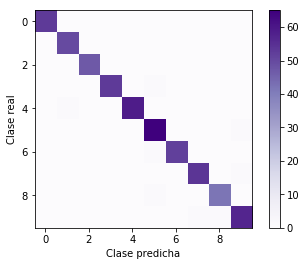

In [134]:
plt.imshow(confusion_matrix(y_test, y_predicted_nn), cmap="Purples")
plt.colorbar()
plt.xticks()
plt.yticks()
plt.xlabel("Clase predicha")
plt.ylabel("Clase real");

## Análisis de resultados

Analiza con más detalle los resultados del perceptrón. 

* ¿Podrías dibujar los casos en los que se equivoca?.
* Revisando los casos que se equivoca... ¿podrías identificar casos que son outliers? (casos que se equivoca pero es lógico porque no están bien etiquetados en el dataset original)

Tip: Apoyate en la función `dibuja_digito`.

In [135]:
def dibuja_digito(index, data_feature, real_class, predicted_class):
    fig = plt.figure(figsize=(2, 2))
    plt.imshow(data_feature.reshape(8,8), cmap=plt.cm.binary, interpolation='nearest')
    plt.text(10, 5, "Index: " + str(index))
    plt.text(10, 6, "Real: " + str(real_class))
    plt.text(10, 7, "Predicted: " + str(predicted_class))

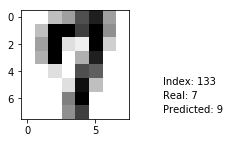

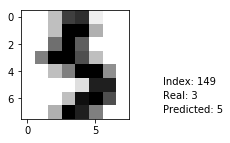

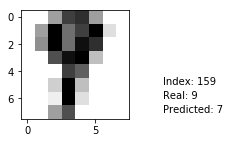

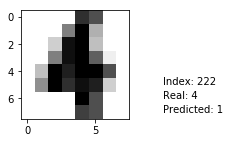

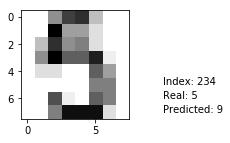

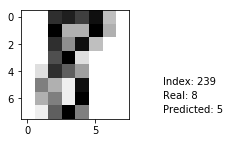

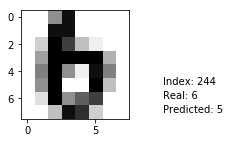

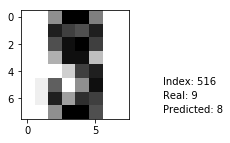

In [136]:
for index, (value1, value2) in enumerate(zip(y_test, y_predicted_nn)):
    if value1 != value2:
        dibuja_digito(index, X_test[index], value1, value2)

## Eliminación de outliers

Elimina los outliers del dataset de test, vuelve a entrenar la red neuronal con un random seed aleatorio y comprueba los resultados con el nuevo dataset de test reducido.

    * Analiza los resultados
    * ¿Es correcto lo que hemos hecho?
    * ¿Que crees que sucedería si eliminasemos tambien los outliers del dataset de entrenamiento?. ¿Mejorarian los resultados?. Solo elabora una respuesta, no es necesario implementar esto en codigo.


In [151]:
#Eliminamos los outliers del cojunto de test (X_test)
X_test_no = X_test

X_test_no = np.delete(X_test_no, 149, 0)
X_test_no = np.delete(X_test_no, 338, 0)
X_test_no = np.delete(X_test_no, 514, 0)

(540, 64)

In [153]:
#Eliminamos los outliers del cojunto de test (y_test)

y_test_no = y_test

y_test_no = np.delete(y_test_no, 149, 0)
y_test_no = np.delete(y_test_no, 338, 0)
y_test_no = np.delete(y_test_no, 514, 0)


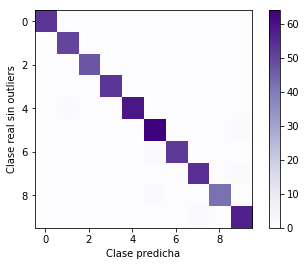

In [154]:
#calculamos los resultados sin outliers
y_predicted_no = nn.predict(X_test_no)

plt.imshow(confusion_matrix(y_test_no, y_predicted_no), cmap="Purples")
plt.colorbar()
plt.xticks()
plt.yticks()
plt.xlabel("Clase predicha")
plt.ylabel("Clase real sin outliers");

In [155]:
confusion_matrix(y_test_no, y_predicted_no)

array([[53,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 50,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0, 47,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 53,  0,  0,  0,  0,  0,  0],
       [ 0,  1,  0,  0, 59,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0, 64,  0,  0,  0,  1],
       [ 0,  0,  0,  0,  0,  1, 52,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 54,  0,  1],
       [ 0,  0,  0,  0,  0,  1,  0,  0, 42,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  1,  0, 57]])

In [156]:
#Porcentaje de acierto
print(nn.score(X_test_no, y_test_no))

0.9888268156424581


## (Extra) Evalúa tus propias imágenes con el modelo entrenado

Genera una imagen de 32x32 píxels y escribe un número en ella. A continuación reconócelo con el mejor modelo que hayas
obtenido en los pasos anteriores.

Recuerda que en la descripción del dataset se especifica como deben ser los números de entrada:

* Imágenes de 8x8 con valores en escala de grises entre 0 y 16
* Número en blanco sobre un fondo negro.

Por último:

* Evalua los resultados obtenidos. ¿cómo podríamos mejorarlos?

In [139]:
from skimage import data, io, filters
import os
from scipy import ndimage, misc

img = io.imread("tu_digito.png")
img2 = io.imread("mi_digito.png")

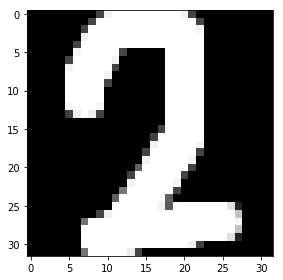

In [140]:
io.imshow(img)
img = misc.imresize(img, (8, 8))
io.show()

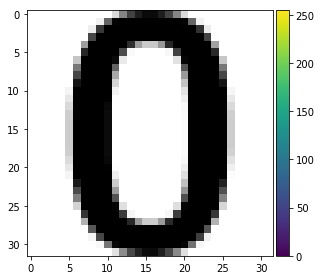

In [141]:
io.imshow(img2)
img2 = misc.imresize(img2, (8, 8))
io.show()

In [157]:
y_predicted_nn1 = nn.predict(img2)

ValueError: Found array with dim 3. Estimator expected <= 2.

In [143]:
print(img2.shape)

(8, 8, 4)
